In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sm
from matplotlib.colors import ListedColormap
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from sklearn.preprocessing import StandardScaler

# Constants for easy modification
DATA_PATH = ""
AQI_FILE = os.path.join(DATA_PATH, "AQI_calculated.csv")
POPULATION_FILE = os.path.join(DATA_PATH, "population_indicators.csv")
ROADS_FILE = os.path.join(DATA_PATH, "hotosm_rwa_roads_lines_geojson.geojson")
SECTORS_SHAPEFILE = os.path.join(DATA_PATH, "rwa_sector/Sector.shp")
OUTPUT_PATH = "output/"
SAVE_FIGURES = True

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Load datasets
def load_data():
    # Load air quality data
    air_df = pd.read_csv(AIR_QUALITY_FILE)
    
    # Load poverty data
    poverty_df = pd.read_csv(POVERTY_FILE)
    
    # Load population data
    population_df = pd.read_csv(POPULATION_FILE)
    
    # Load sectors shapefile
    sectors_gdf = gpd.read_file(SECTORS_SHAPEFILE)
    
    return air_df, poverty_df, population_df, sectors_gdf

# Data preprocessing and integration


def preprocess_data(aqi_file, population_file, roads_file, sectors_shapefile):
    # Load the AQI data that already includes poverty metrics
    aqi_df = pd.read_csv(aqi_file)

    # Load population data
    population_df = pd.read_csv(population_file)

    # Load roads data
    roads_gdf = gpd.read_file(roads_file)

    # Load sectors shapefile
    sectors_gdf = gpd.read_file(sectors_shapefile)

    # Create date column as datetime if not already
    if 'date_obj' not in aqi_df.columns:
        aqi_df['date_obj'] = pd.to_datetime(aqi_df['date'])

    # Calculate average air quality by sector (aggregating monthly data)
    aqi_by_sector = aqi_df.groupby('Sect_ID').agg({
        'AQI': 'mean',
        'NO2_mean': 'mean',
        'CO_mean': 'mean',
        'SO2_mean': 'mean',
        'O3_mean': 'mean',
        'AER_mean': 'mean',
        'poverty_index': 'first',
        'poor_percent': 'first',
        'avg_deprivation_intensity': 'first',
        'District': 'first',
        'Province': 'first',
        'Name': 'first'
    }).reset_index()

    # Prepare district level population data for merging
    district_data = population_df[[
        'district', 'population_density', 'urban_percentage', 'rural_percentage']]
    district_data = district_data.rename(columns={'district': 'District'})

    # Merge district population data with sector AQI data
    merged_df = aqi_by_sector.merge(district_data, on='District', how='left')

    # Create urban-rural-periurban classification based on district urban percentage
    merged_df['urbanization_class'] = pd.cut(
        merged_df['urban_percentage'],
        bins=[0, 25, 75, 100],
        labels=['Rural', 'Peri-urban', 'Urban']
    )

    # Create alternative NO2-based urbanization proxy
    merged_df['NO2_urbanization'] = pd.qcut(
        merged_df['NO2_mean'],
        q=[0, 0.33, 0.67, 1],
        labels=['Rural', 'Peri-urban', 'Urban']
    )

    # Create poverty categories
    merged_df['poverty_category'] = pd.qcut(
        merged_df['poverty_index'],
        q=[0, 0.25, 0.5, 0.75, 1.0],
        labels=['Low Poverty', 'Medium-Low Poverty',
                'Medium-High Poverty', 'High Poverty']
    )

    # Calculate road density and proximity metrics for each sector
    # Convert CRS of roads to match sectors if needed
    if roads_gdf.crs != sectors_gdf.crs:
        roads_gdf = roads_gdf.to_crs(sectors_gdf.crs)

    # Calculate road density (length of roads per sector area)
    road_density = {}
    road_proximity = {}

    for idx, sector in sectors_gdf.iterrows():
        # Get roads within this sector
        sector_roads = roads_gdf[roads_gdf.intersects(sector.geometry)]

        # Calculate total road length within sector
        if len(sector_roads) > 0:
            # Clip roads to sector boundary
            clipped_roads = gpd.clip(sector_roads, sector.geometry)
            total_length = clipped_roads.geometry.length.sum()
            sector_area = sector.geometry.area

            # Road density = total road length / sector area
            road_density[sector['Sect_ID']] = total_length / sector_area
        else:
            road_density[sector['Sect_ID']] = 0

        # Calculate distance to nearest road
        if len(roads_gdf) > 0:
            # Use centroid of sector for simplicity
            centroid = sector.geometry.centroid
            distances = [centroid.distance(road)
                         for road in roads_gdf.geometry]
            road_proximity[sector['Sect_ID']] = min(distances)
        else:
            road_proximity[sector['Sect_ID']] = float('nan')

    # Add road metrics to merged dataframe
    merged_df['road_density'] = merged_df['Sect_ID'].map(road_density)
    merged_df['road_proximity'] = merged_df['Sect_ID'].map(road_proximity)

    # Normalize road metrics
    merged_df['road_density_norm'] = (merged_df['road_density'] - merged_df['road_density'].min()) / \
        (merged_df['road_density'].max() - merged_df['road_density'].min())

    # Handle NaN values in road proximity
    merged_df['road_proximity'] = merged_df['road_proximity'].fillna(
        merged_df['road_proximity'].max())
    merged_df['road_proximity_norm'] = 1 - (merged_df['road_proximity'] - merged_df['road_proximity'].min()) / \
        (merged_df['road_proximity'].max() - merged_df['road_proximity'].min())

    # Merge with geospatial data
    geo_merged_df = sectors_gdf.merge(merged_df, on='Sect_ID', how='inner')

    return aqi_df, merged_df, geo_merged_df
# Enhanced correlation analysis


def correlation_analysis(merged_df):
    # Make a copy of the data and handle missing values
    analysis_df = merged_df.copy()

    # List key variables for correlation
    corr_vars = ['AQI', 'poverty_index', 'population_density']

    # Add optional variables if they exist
    for var in ['urban_percentage', 'road_density_norm', 'road_proximity_norm']:
        if var in analysis_df.columns:
            corr_vars.append(var)

    # Fill NaN values with median
    for var in corr_vars:
        if var in analysis_df.columns:
            analysis_df[var] = analysis_df[var].fillna(
                analysis_df[var].median())

    # Calculate correlation matrix
    correlation_matrix = analysis_df[corr_vars].corr()

    # Overall correlation
    overall_corr = analysis_df['AQI'].corr(analysis_df['poverty_index'])
    print(f"Overall correlation between AQI and poverty: {overall_corr:.4f}")

    # Correlation by urbanization class if available
    if 'urbanization_class' in analysis_df.columns:
        for urban_class in analysis_df['urbanization_class'].unique():
            class_df = analysis_df[analysis_df['urbanization_class']
                                   == urban_class]
            if len(class_df) > 5:  # Only calculate if enough data points
                class_corr = class_df['AQI'].corr(class_df['poverty_index'])
                print(f"Correlation in {urban_class} areas: {class_corr:.4f}")

    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True,
                cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Key Variables')
    if SAVE_FIGURES:
        plt.savefig(os.path.join(OUTPUT_PATH, 'correlation_matrix.png'),
                    dpi=300, bbox_inches='tight')
    plt.show()

    # Create enhanced scatter plot with urban/rural coloring if available
    plt.figure(figsize=(12, 8))

    if 'urbanization_class' in analysis_df.columns:
        colors = {'Urban': '#E74C3C',
                  'Peri-urban': '#F39C12', 'Rural': '#27AE60'}

        for category in analysis_df['urbanization_class'].unique():
            subset = analysis_df[analysis_df['urbanization_class'] == category]
            plt.scatter(subset['poverty_index'], subset['AQI'],
                        c=colors.get(category, 'blue'), label=category, alpha=0.7, s=50)
    else:
        plt.scatter(analysis_df['poverty_index'], analysis_df['AQI'],
                    color='blue', alpha=0.7, s=50)

    # Add regression line for the whole dataset
    try:
        x = analysis_df['poverty_index']
        y = analysis_df['AQI']
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(np.sort(x), p(np.sort(x)), "r--", alpha=0.8, linewidth=2)
    except Exception as e:
        print(f"Error fitting regression line: {e}")

    plt.title(
        f'Correlation between Poverty Index and Air Quality Index\nCorrelation coefficient = {overall_corr:.2f}')
    plt.xlabel('Poverty Index')
    plt.ylabel('Air Quality Index')
    if 'urbanization_class' in analysis_df.columns:
        plt.legend()
    plt.grid(True, alpha=0.3)
    if SAVE_FIGURES:
        plt.savefig(os.path.join(
            OUTPUT_PATH, 'poverty_aqi_correlation.png'), dpi=300, bbox_inches='tight')
    plt.show()

    return correlation_matrix

def multivariate_regression(merged_df):
    # Prepare data for regression
    X_vars = ['poverty_index', 'population_density',
              'urban_percentage', 'road_density_norm']

    # Create a copy to avoid modifying the original
    analysis_df = merged_df.copy()

    # Handle missing values
    for var in X_vars:
        if var in analysis_df.columns:
            analysis_df[var] = analysis_df[var].fillna(
                analysis_df[var].median())

    # Drop rows with any remaining NaN values
    analysis_df = analysis_df.dropna(subset=X_vars + ['AQI'])

    # Standardize variables to address scaling issues
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(analysis_df[X_vars])
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_vars)

    # Add constant
    X_scaled_df = sm.add_constant(X_scaled_df)
    y = analysis_df['AQI']

    try:
        # Run regression with more robust method
        # QR decomposition can be more stable
        model = sm.OLS(y, X_scaled_df).fit(method='qr')
        print(model.summary())

        # Calculate VIFs
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_scaled_df.columns
        vif_data["VIF"] = [variance_inflation_factor(
            X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
        print("\nVariance Inflation Factors:")
        print(vif_data)

        # Create partial plots for each variable
        plt.figure(figsize=(15, 5))

        for i, var in enumerate(X_vars):
            plt.subplot(1, len(X_vars), i+1)
            # Generate partial residual plot data
            plt.scatter(X_scaled_df[var], model.resid +
                        model.params[var] * X_scaled_df[var], alpha=0.6)
            plt.xlabel(var)
            plt.ylabel('Partial Residual')
            plt.title(f'Partial Residual Plot: {var}')
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        if SAVE_FIGURES:
            plt.savefig(os.path.join(
                OUTPUT_PATH, 'regression_partial_plots.png'), dpi=300, bbox_inches='tight')
        plt.show()

        return model

    except Exception as e:
        print(f"Regression Error: {e}")
        print("Trying with reduced model...")

        # Try with fewer variables
        reduced_vars = ['poverty_index', 'population_density']
        X_reduced = analysis_df[reduced_vars]
        X_reduced = sm.add_constant(X_reduced)

        try:
            reduced_model = sm.OLS(y, X_reduced).fit()
            print(reduced_model.summary())
            return reduced_model
        except Exception as e2:
            print(f"Reduced model error: {e2}")
            return None

# Temporal trend analysis
def temporal_trend_analysis(air_df, merged_df):
    # Merge air data with sector classifications
    temporal_df = air_df.merge(
        merged_df[['Sect_ID', 'poverty_category', 'urbanization_class']],
        on='Sect_ID', how='inner'
    )
    
    # Ensure date is datetime
    if not pd.api.types.is_datetime64_dtype(temporal_df['date_obj']):
        temporal_df['date_obj'] = pd.to_datetime(temporal_df['date'])
    
    # Create monthly time series by poverty category
    monthly_poverty = temporal_df.groupby([pd.Grouper(key='date_obj', freq='M'), 'poverty_category']).agg({
        'AQI': 'mean',
        'NO2_mean': 'mean'
    }).reset_index()
    
    # Create monthly time series by urbanization class
    monthly_urban = temporal_df.groupby([pd.Grouper(key='date_obj', freq='M'), 'urbanization_class']).agg({
        'AQI': 'mean',
        'NO2_mean': 'mean'
    }).reset_index()
    
    # Plot time series by poverty category
    plt.figure(figsize=(14, 7))
    for category in monthly_poverty['poverty_category'].unique():
        subset = monthly_poverty[monthly_poverty['poverty_category'] == category]
        plt.plot(subset['date_obj'], subset['AQI'], label=category)
    
    plt.title('Air Quality Trends by Poverty Level (2020-2025)')
    plt.xlabel('Date')
    plt.ylabel('Air Quality Index')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(os.path.join(OUTPUT_PATH, 'aqi_trends_by_poverty.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot time series by urbanization class
    plt.figure(figsize=(14, 7))
    for category in monthly_urban['urbanization_class'].unique():
        subset = monthly_urban[monthly_urban['urbanization_class'] == category]
        plt.plot(subset['date_obj'], subset['AQI'], label=category)
    
    plt.title('Air Quality Trends by Urbanization Class (2020-2025)')
    plt.xlabel('Date')
    plt.ylabel('Air Quality Index')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(os.path.join(OUTPUT_PATH, 'aqi_trends_by_urbanization.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate trend slopes for each category
    trend_results = {}
    
    for category in monthly_poverty['poverty_category'].unique():
        subset = monthly_poverty[monthly_poverty['poverty_category'] == category]
        x = np.arange(len(subset))
        y = subset['AQI'].values
        slope, _, _, _, _ = stats.linregress(x, y)
        trend_results[f"Poverty: {category}"] = slope
    
    for category in monthly_urban['urbanization_class'].unique():
        subset = monthly_urban[monthly_urban['urbanization_class'] == category]
        x = np.arange(len(subset))
        y = subset['AQI'].values
        slope, _, _, _, _ = stats.linregress(x, y)
        trend_results[f"Urbanization: {category}"] = slope
    
    print("\nTrend Analysis (AQI change per month):")
    for category, slope in trend_results.items():
        print(f"{category}: {slope:.4f}")
    
    return monthly_poverty, monthly_urban

# Spatial pattern analysis
def spatial_pattern_analysis(geo_merged_df):
    # Create bivariate map of AQI and poverty
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Normalize variables for bivariate mapping
    geo_merged_df['aqi_norm'] = (geo_merged_df['AQI'] - geo_merged_df['AQI'].min()) / (geo_merged_df['AQI'].max() - geo_merged_df['AQI'].min())
    geo_merged_df['poverty_norm'] = (geo_merged_df['poverty_index'] - geo_merged_df['poverty_index'].min()) / (geo_merged_df['poverty_index'].max() - geo_merged_df['poverty_index'].min())
    
    # Create bivariate categories (3x3 grid)
    geo_merged_df['aqi_class'] = pd.qcut(geo_merged_df['aqi_norm'], 3, labels=[0, 1, 2])
    geo_merged_df['poverty_class'] = pd.qcut(geo_merged_df['poverty_norm'], 3, labels=[0, 1, 2])
    geo_merged_df['bivar_class'] = geo_merged_df['poverty_class'].astype(int) * 3 + geo_merged_df['aqi_class'].astype(int)
    
    # Bivariate color scheme
    bivar_colors = [
        '#e8e8e8', '#e4acac', '#c85a5a',  # Low poverty
        '#b0d5df', '#ad9ea5', '#985356',   # Medium poverty
        '#64acbe', '#627f8c', '#574249'    # High poverty
    ]
    
    # Plot bivariate map
    geo_merged_df.plot(
        column='bivar_class',
        categorical=True,
        cmap=ListedColormap(bivar_colors),
        ax=ax,
        legend=False
    )
    
    # Add province boundaries
    province_boundaries = geo_merged_df.dissolve(by='Province')
    province_boundaries.boundary.plot(ax=ax, color='black', linewidth=1.5)
    
    # Add custom legend
    from matplotlib.patches import Patch
    legend_elements = []
    
    # Create a grid of rectangles for the legend
    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            legend_elements.append(
                Patch(facecolor=bivar_colors[idx], 
                      label=f"Poverty: {['Low', 'Medium', 'High'][i]}, AQI: {['Low', 'Medium', 'High'][j]}")
            )
    
    ax.legend(handles=legend_elements, title="Poverty and Air Quality", 
              loc="lower right", fontsize=8)
    
    ax.set_title('Bivariate Map of Poverty and Air Quality')
    ax.set_axis_off()
    if SAVE_FIGURES:
        plt.savefig(os.path.join(OUTPUT_PATH, 'bivariate_poverty_aqi_map.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create urbanization map
    plt.figure(figsize=(12, 10))
    geo_merged_df.plot(
        column='urbanization_class', 
        categorical=True,
        cmap=ListedColormap(['#27AE60', '#F39C12', '#E74C3C']),
        ax=plt.gca(),
        legend=True,
        legend_kwds={'title': 'Urbanization Class'}
    )
    
    # Add province boundaries
    province_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1.5)
    
    plt.title('Urbanization Classification of Rwanda Sectors')
    plt.axis('off')
    if SAVE_FIGURES:
        plt.savefig(os.path.join(OUTPUT_PATH, 'urbanization_map.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return geo_merged_df


def main():
    print("Preprocessing and integrating data...")
    aqi_df, merged_df, geo_merged_df = preprocess_data(
        AQI_FILE, POPULATION_FILE, ROADS_FILE, SECTORS_SHAPEFILE
    )

    print("Performing correlation analysis...")
    correlation_matrix = correlation_analysis(merged_df)

    print("Running multivariate regression analysis...")
    regression_model = multivariate_regression(merged_df)

    print("Analyzing temporal trends...")
    monthly_poverty, monthly_urban = temporal_trend_analysis(aqi_df, merged_df)

    print("Analyzing spatial patterns...")
    geo_analysis = spatial_pattern_analysis(geo_merged_df)

    print("Analysis complete. Results saved to:", OUTPUT_PATH)

    return {
        'aqi_data': aqi_df,
        'merged_data': merged_df,
        'geo_data': geo_merged_df,
        'correlation': correlation_matrix,
        'regression': regression_model,
        'monthly_poverty': monthly_poverty,
        'monthly_urban': monthly_urban
    }

Preprocessing and integrating data...
Performing correlation analysis...
Overall correlation between AQI and poverty: -0.0855
Correlation in Urban areas: -0.2296
Correlation in Rural areas: nan
Correlation in Peri-urban areas: 0.0000


C:\Users\STUDENT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\STUDENT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\STUDENT\\Desktop\\SPRING2025\\MBDA\\project\\air-quality\\output\\correlation_matrix.png'

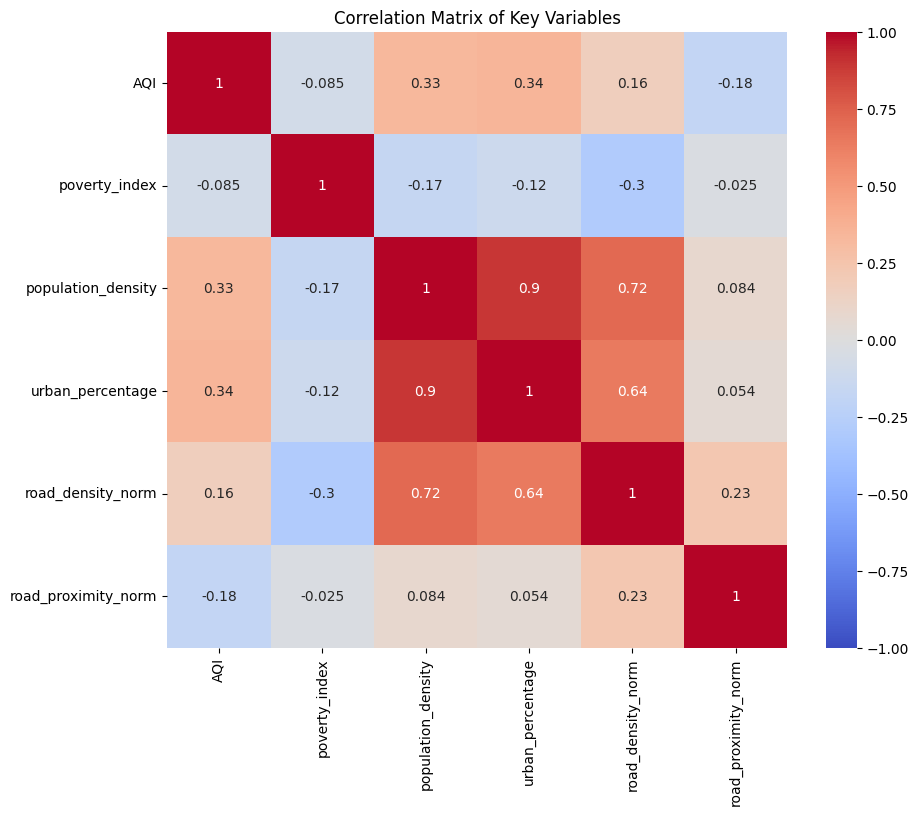

In [6]:
if __name__ == "__main__":
    results = main()